In [13]:
#!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf # Yahoo finance 에서 제공하는 데이터에 접근 가능

There are 1510 observations in the training data
There are 251 observations in the test data


<Axes: xlabel='Date'>

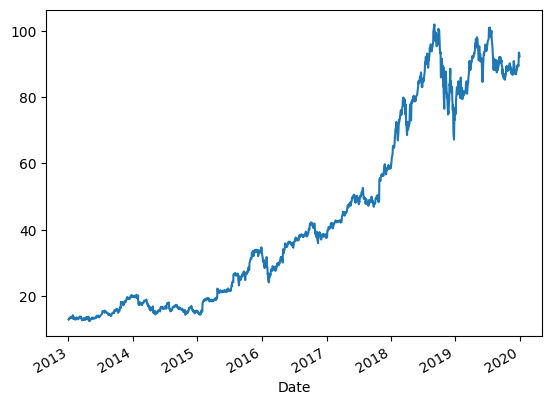

In [14]:
# 아마존의 2013년 부터 2018년까지 일일 주가를 학습 데이터로
# 2019년 데이터를 테스트 데이터로 사용

AMZN = yf.download('AMZN',
                  start = '2013-01-01',
                  end = '2019-12-31',
                  progress = False)

# 수정종가(Adj close), 시가(Open), 최고가(High), 최저가(Low), 종가(Close). 거래량(Volume)
all_data = AMZN[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)
all_data.head(10)

print("There are "+str(all_data[:'2018'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2019':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()

In [15]:
all_data.head()

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2013-01-02,12.87,12.80,12.90,12.66,12.87,65420000
2013-01-03,12.92,12.86,13.04,12.82,12.92,55018000
2013-01-04,12.96,12.88,12.99,12.83,12.96,37484000
2013-01-07,13.42,13.15,13.49,13.13,13.42,98200000
2013-01-08,13.32,13.35,13.45,13.18,13.32,60214000


In [16]:
# 데이터 구조 확인
all_data.describe()

,Adj Close,Open,High,Low,Close,Volume
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1.761000e+03
mean,44.287019,44.303759,44.707183,43.823935,44.287019,8.001791e+07
std,28.843229,28.868428,29.112523,28.551651,28.843229,4.494416e+07
min,12.410000,12.450000,12.650000,12.290000,12.410000,1.762600e+07
25%,17.930000,17.920000,18.050000,17.720000,17.930000,5.280600e+07
50%,36.340000,36.320000,36.480000,35.980000,36.340000,6.772400e+07
75%,74.850000,74.710000,76.140000,73.820000,74.850000,9.229200e+07
max,101.980000,101.910000,102.530000,100.650000,101.980000,4.771220e+08


2. RNN/LSTM을 위한 학습데이터 만들기
단변량 주식 가격 시계열로 부터 학습데이터를 생성 * MANY 2 MANY * MANY 2 ONE

2-1. MANY 2 MANY
과거 X일의 가격을 사용해서 미래 Y일의 가격을 예측
빨간색 창을 시리즈에 따라 움직여서 샘플 을 만듦
각 샘플은 5가지 입력값과 2개의 출력값을 가짐
타임스텝 : 각 샘플의 입력값
feature : 매 타임스텝마다 feature라고 불리는 하나의 숫자를 가짐. feature의 수는 여러개일 수 있음
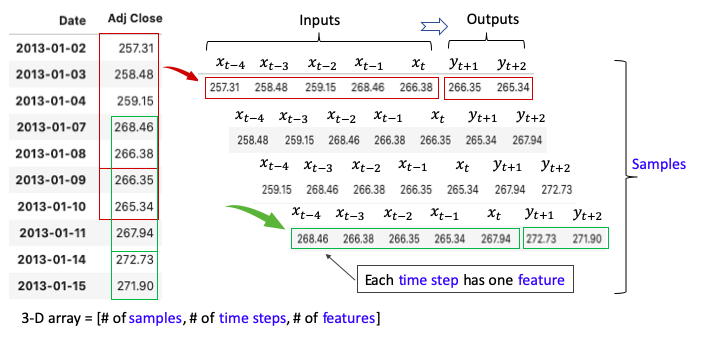

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input:
        all_data: dataframe with dates and price data
    output:
        X_train, y_train: data from 2013/1/1-2018/12/31
        X_test : data from 2019-
        sc :     instantiated MinMaxScaler object fit to the training data
    """
    # Create training and test set
    ts_train = all_data[:'2018'].iloc[:, 0:1].values
    ts_test = all_data['2019':].iloc[:, 0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # Scale the data
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # Create training data of s samples and t time steps
    X_train = []
    y_train = []
    for i in range(time_steps, ts_train_len - for_periods):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Prepare inputs for X_test
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs) - len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps, len(inputs) - for_periods):
        X_test.append(inputs[i-time_steps:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc

# Example usage
# all_data should be a DataFrame with a DateTime index and a column "Adj Close"
# For example:
# all_data = pd.read_csv('your_data.csv', index_col='Date', parse_dates=True)
# X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, time_steps=60, for_periods=1)


In [32]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5,2)
X_train.shape[0], X_train.shape[1]

(1503, 5)

In [33]:
# Convert the 3D shape of X_train to a data frame so we can see:
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1503 samples in the training data
There are 249 samples in the test data


4. LSTM 모델

In [34]:

def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers.schedules import ExponentialDecay

    # Learning rate schedule
    initial_lr = 0.01
    lr_schedule = ExponentialDecay(
        initial_learning_rate = initial_lr,
        decay_steps = 100000,
        decay_rate = 0.96,
        staircase = True
    )

    # Optimizer
    optimizer = SGD(learning_rate = lr_schedule, momentum = 0.9, nesterov = False)

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50,
                           return_sequences = True,
                           input_shape = (X_train.shape[1], 1),
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units = 2))

    # Compiling
    my_LSTM_model.compile(optimizer = optimizer, loss = 'mean_squared_error')

    # Fitting to the training set
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction


In [35]:

def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot())

8/8 [==============================] - 1s 3ms/step


(5.788219, <Axes: xlabel='Date'>)

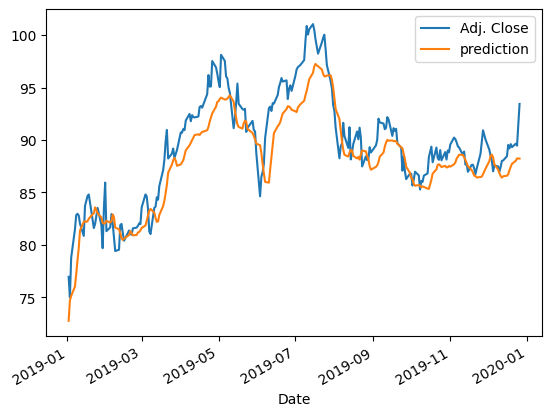

In [36]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [37]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test=all_data.loc['2019':,'Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)

    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [38]:
confirm_result(y_test, y_pred)

,Results
MAE,1.94691
RMSE,2.40587
RMSLE,0.02655
R2,0.77506


5. GRU 모델

In [25]:
def GRU_model(X_train, y_train, X_test, sc):
    from keras.models import Sequential
    from keras.layers import Dense, GRU
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.optimizers.schedules import ExponentialDecay

    # Learning rate schedule
    initial_lr = 0.01
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    # Optimizer
    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=False)

    # Check the shapes of the input data
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)

    # Reshape X_train and X_test if necessary
    if len(X_train.shape) != 3:
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        print("Reshaped X_train:", X_train.shape)
        print("Reshaped X_test:", X_test.shape)

    # The GRU architecture
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50,
                         return_sequences = True,
                         input_shape = (X_train.shape[1], 1),
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50,
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer = optimizer, loss = 'mean_squared_error')

    # Fitting to the training set
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)

    # Making predictions
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction


X_train shape: (1504, 5, 1)
y_train shape: (1504, 2)
X_test shape: (249, 5, 1)
8/8 [==============================] - 1s 3ms/step


(3.4662786, <Axes: xlabel='Date'>)

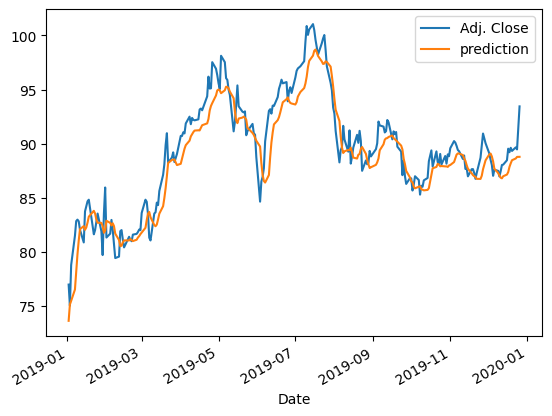

In [26]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [27]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=all_data.loc['2019':,'Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [30]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,1.46791
RMSE,1.86179
RMSLE,0.02069
R2,0.86529
